In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle


import keras
from keras.layers import InputLayer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler

import util.items as items

Using TensorFlow backend.


In [3]:
items.getItemPrices('Abyssal_whip')[-10:]

[2663958,
 2643140,
 2626840,
 2614224,
 2606262,
 2593007,
 2593049,
 2587581,
 2581066,
 2581709]

In [4]:
items.getItemInfo('Abyssal_whip')

{'members': 'True',
 'edible': 'False',
 'update': '/w/Update:Slayer_Skill',
 'quest': 'No',
 'destroy': 'Drop',
 'image': '/w/File:Abyssal_whip.png',
 'lowAlch': '48000',
 'examine': 'A weapon from the abyss.',
 'highAlch': '72000',
 'storeprice': 'N/A',
 'seller': 'N/A',
 'equipable': 'True',
 'weight': '0.453',
 'released': '26 January 2005',
 'storeCurrency': 'N/A',
 'name': 'Abyssal_whip',
 'alchable': 'True',
 'exchangePrice': '2622266',
 'tradeable': 'True',
 'buyLimit': '70',
 'noteable': 'True',
 'stackable': 'False'}

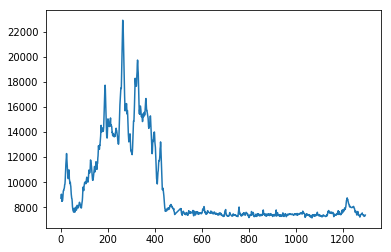

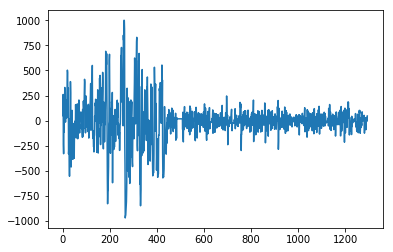

In [47]:
item = 'Rune_boots'
prices = items.getItemPrices(item)
changes = items.getPriceChanges(item)
plt.plot(prices)
plt.show()
plt.plot(changes)
plt.show()

In [48]:
def minMax(data):
    d = []
    ma = max(data)
    mi = min(data)
    for i in range(len(data)):
        d.append((data[i]-mi)/(ma-mi))
    return d

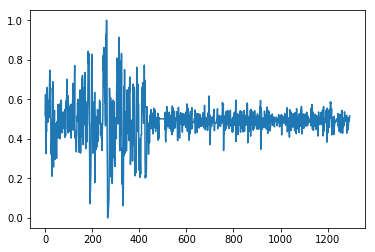

In [49]:
s_changes = minMax(changes)
plt.plot(s_changes)
plt.show()

In [50]:
x = []
for i in range(len(s_changes)-5):
    x.append(s_changes[i:i+5])
print(x[0],x[-1])

[0.5177845528455285, 0.6244918699186992, 0.3719512195121951, 0.3246951219512195, 0.5711382113821138] [0.47764227642276424, 0.508130081300813, 0.49441056910569103, 0.4883130081300813, 0.5060975609756098]


In [51]:
y = []
p = []
for i in range(5,len(s_changes)):
    y.append(s_changes[i])
    p.append(prices[i])
print(y[0],y[1],y[-2],y[-1])

In [52]:
s1 = int(len(y)*.7)
s2  =int(len(y)*.85)
x_train = np.array(x[:s1])
y_train = np.array(y[:s1])
x_val = np.array(x[s1:s2])
y_val = np.array(y[s1:s2])
x_test = np.array(x[s2:])
y_test = np.array(y[s2:])
p_test = np.array(p[s2:])
print(len(x_train),len(y_train),len(x_val),len(y_val),len(x_test),len(y_test),len(p_test))
print(x_train[0],y_train[0],x_test[0],y_test[0])

902 902 194 194 194 194 194
[0.51778455 0.62449187 0.37195122 0.32469512 0.57113821] 0.4344512195121951 [0.48272358 0.52591463 0.5050813  0.45325203 0.50457317] 0.4649390243902439


In [53]:
model = Sequential()
model.add(Dense(5, input_dim=5))
model.add(Dense(5, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))

In [54]:
sgd = SGD(lr=0.1)
model.compile(loss='mse',
              optimizer=sgd,
              metrics=['mse'])

history = model.fit(x_train, y_train,
            validation_data=(x_val,y_val),
            epochs=10,
            batch_size=1)
score = model.evaluate(x_test, y_test, batch_size=1)
print(score)

Train on 902 samples, validate on 194 samples
Epoch 1/10


  1/902 [..............................] - ETA: 3:21 - loss: 0.1586 - mean_squared_error: 0.1586

 10/902 [..............................] - ETA: 24s - loss: 0.0371 - mean_squared_error: 0.0371 

 21/902 [..............................] - ETA: 13s - loss: 0.0246 - mean_squared_error: 0.0246

 37/902 [>.............................] - ETA: 8s - loss: 0.0163 - mean_squared_error: 0.0163 

 58/902 [>.............................] - ETA: 6s - loss: 0.0130 - mean_squared_error: 0.0130

 82/902 [=>............................] - ETA: 4s - loss: 0.0166 - mean_squared_error: 0.0166

106/902 [==>...........................] - ETA: 4s - loss: 0.0183 - mean_squared_error: 0.0183

130/902 [===>..........................] - ETA: 3s - loss: 0.0168 - mean_squared_error: 0.0168

154/902 [====>.........................] - ETA: 3s - loss: 0.0170 - mean_squared_error: 0.0170

179/902 [====>.........................] - ETA: 2s - loss: 0.0157 - mean_squared_error: 0.0157

204/902 [=====>........................] - ETA: 2s - loss: 0.0157 - mean_squared_error: 0.0157

228/902 [======>.......................] - ETA: 2s - loss: 0.0172 - mean_squared_error: 0.0172

252/902 [=======>......................] - ETA: 2s - loss: 0.0169 - mean_squared_error: 0.0169

277/902 [========>.....................] - ETA: 2s - loss: 0.0181 - mean_squared_error: 0.0181

301/902 [=========>....................] - ETA: 1s - loss: 0.0182 - mean_squared_error: 0.0182

324/902 [=========>....................] - ETA: 1s - loss: 0.0179 - mean_squared_error: 0.0179

348/902 [==========>...................] - ETA: 1s - loss: 0.0178 - mean_squared_error: 0.0178

372/902 [===========>..................] - ETA: 1s - loss: 0.0173 - mean_squared_error: 0.0173

396/902 [============>.................] - ETA: 1s - loss: 0.0174 - mean_squared_error: 0.0174

420/902 [============>.................] - ETA: 1s - loss: 0.0171 - mean_squared_error: 0.0171

444/902 [=============>................] - ETA: 1s - loss: 0.0170 - mean_squared_error: 0.0170

468/902 [==============>...............] - ETA: 1s - loss: 0.0168 - mean_squared_error: 0.0168

493/902 [===============>..............] - ETA: 1s - loss: 0.0162 - mean_squared_error: 0.0162

516/902 [================>.............] - ETA: 1s - loss: 0.0159 - mean_squared_error: 0.0159

541/902 [================>.............] - ETA: 0s - loss: 0.0169 - mean_squared_error: 0.0169

564/902 [=================>............] - ETA: 0s - loss: 0.0166 - mean_squared_error: 0.0166

585/902 [==================>...........] - ETA: 0s - loss: 0.0166 - mean_squared_error: 0.0166

611/902 [===================>..........] - ETA: 0s - loss: 0.0164 - mean_squared_error: 0.0164

634/902 [====================>.........] - ETA: 0s - loss: 0.0166 - mean_squared_error: 0.0166

659/902 [====================>.........] - ETA: 0s - loss: 0.0163 - mean_squared_error: 0.0163

683/902 [=====================>........] - ETA: 0s - loss: 0.0163 - mean_squared_error: 0.0163

707/902 [======================>.......] - ETA: 0s - loss: 0.0160 - mean_squared_error: 0.0160

731/902 [=======================>......] - ETA: 0s - loss: 0.0158 - mean_squared_error: 0.0158

757/902 [========================>.....] - ETA: 0s - loss: 0.0158 - mean_squared_error: 0.0158

781/902 [========================>.....] - ETA: 0s - loss: 0.0157 - mean_squared_error: 0.0157

806/902 [=========================>....] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.0155

828/902 [==========================>...] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.0155

853/902 [===========================>..] - ETA: 0s - loss: 0.0152 - mean_squared_error: 0.0152

876/902 [============================>.] - ETA: 0s - loss: 0.0151 - mean_squared_error: 0.0151

900/902 [============================>.] - ETA: 0s - loss: 0.0151 - mean_squared_error: 0.0151

902/902 [==============================] - 2s 3ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0015 - val_mean_squared_error: 0.0015


Epoch 2/10
  1/902 [..............................] - ETA: 2s - loss: 0.0157 - mean_squared_error: 0.0157

 18/902 [..............................] - ETA: 2s - loss: 0.0250 - mean_squared_error: 0.0250

 42/902 [>.............................] - ETA: 2s - loss: 0.0147 - mean_squared_error: 0.0147

 65/902 [=>............................] - ETA: 2s - loss: 0.0129 - mean_squared_error: 0.0129

 89/902 [=>............................] - ETA: 1s - loss: 0.0107 - mean_squared_error: 0.0107

114/902 [==>...........................] - ETA: 1s - loss: 0.0115 - mean_squared_error: 0.0115

138/902 [===>..........................] - ETA: 1s - loss: 0.0127 - mean_squared_error: 0.0127

163/902 [====>.........................] - ETA: 1s - loss: 0.0125 - mean_squared_error: 0.0125

188/902 [=====>........................] - ETA: 1s - loss: 0.0115 - mean_squared_error: 0.0115

214/902 [======>.......................] - ETA: 1s - loss: 0.0116 - mean_squared_error: 0.0116

239/902 [======>.......................] - ETA: 1s - loss: 0.0114 - mean_squared_error: 0.0114

264/902 [=======>......................] - ETA: 1s - loss: 0.0114 - mean_squared_error: 0.0114

288/902 [========>.....................] - ETA: 1s - loss: 0.0114 - mean_squared_error: 0.0114

314/902 [=========>....................] - ETA: 1s - loss: 0.0114 - mean_squared_error: 0.0114

336/902 [==========>...................] - ETA: 1s - loss: 0.0112 - mean_squared_error: 0.0112

363/902 [===========>..................] - ETA: 1s - loss: 0.0107 - mean_squared_error: 0.0107

387/902 [===========>..................] - ETA: 1s - loss: 0.0114 - mean_squared_error: 0.0114

411/902 [============>.................] - ETA: 1s - loss: 0.0110 - mean_squared_error: 0.0110

433/902 [=============>................] - ETA: 1s - loss: 0.0112 - mean_squared_error: 0.0112

457/902 [==============>...............] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

481/902 [==============>...............] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

508/902 [===============>..............] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

531/902 [================>.............] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

556/902 [=================>............] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.0107

579/902 [==================>...........] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

603/902 [===================>..........] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

626/902 [===================>..........] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.0104

651/902 [====================>.........] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

674/902 [=====================>........] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

698/902 [======================>.......] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

722/902 [=======================>......] - ETA: 0s - loss: 0.0110 - mean_squared_error: 0.0110

746/902 [=======================>......] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

769/902 [========================>.....] - ETA: 0s - loss: 0.0109 - mean_squared_error: 0.0109

795/902 [=========================>....] - ETA: 0s - loss: 0.0111 - mean_squared_error: 0.0111

820/902 [==========================>...] - ETA: 0s - loss: 0.0109 - mean_squared_error: 0.0109

846/902 [===========================>..] - ETA: 0s - loss: 0.0111 - mean_squared_error: 0.0111

871/902 [===========================>..] - ETA: 0s - loss: 0.0111 - mean_squared_error: 0.0111

897/902 [============================>.] - ETA: 0s - loss: 0.0110 - mean_squared_error: 0.0110

902/902 [==============================] - 2s 2ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0017 - val_mean_squared_error: 0.0017


Epoch 3/10
  1/902 [..............................] - ETA: 2s - loss: 0.0023 - mean_squared_error: 0.0023

 19/902 [..............................] - ETA: 2s - loss: 0.0091 - mean_squared_error: 0.0091

 41/902 [>.............................] - ETA: 2s - loss: 0.0090 - mean_squared_error: 0.0090

 66/902 [=>............................] - ETA: 2s - loss: 0.0080 - mean_squared_error: 0.0080

 90/902 [=>............................] - ETA: 1s - loss: 0.0101 - mean_squared_error: 0.0101

115/902 [==>...........................] - ETA: 1s - loss: 0.0109 - mean_squared_error: 0.0109

139/902 [===>..........................] - ETA: 1s - loss: 0.0108 - mean_squared_error: 0.0108

162/902 [====>.........................] - ETA: 1s - loss: 0.0111 - mean_squared_error: 0.0111

187/902 [=====>........................] - ETA: 1s - loss: 0.0108 - mean_squared_error: 0.0108

212/902 [======>.......................] - ETA: 1s - loss: 0.0101 - mean_squared_error: 0.0101

236/902 [======>.......................] - ETA: 1s - loss: 0.0102 - mean_squared_error: 0.0102

260/902 [=======>......................] - ETA: 1s - loss: 0.0104 - mean_squared_error: 0.0104

283/902 [========>.....................] - ETA: 1s - loss: 0.0101 - mean_squared_error: 0.0101

307/902 [=========>....................] - ETA: 1s - loss: 0.0102 - mean_squared_error: 0.0102

331/902 [==========>...................] - ETA: 1s - loss: 0.0104 - mean_squared_error: 0.0104

356/902 [==========>...................] - ETA: 1s - loss: 0.0113 - mean_squared_error: 0.0113

380/902 [===========>..................] - ETA: 1s - loss: 0.0112 - mean_squared_error: 0.0112

406/902 [============>.................] - ETA: 1s - loss: 0.0109 - mean_squared_error: 0.0109

426/902 [=============>................] - ETA: 1s - loss: 0.0111 - mean_squared_error: 0.0111

450/902 [=============>................] - ETA: 0s - loss: 0.0112 - mean_squared_error: 0.0112

473/902 [==============>...............] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

499/902 [===============>..............] - ETA: 0s - loss: 0.0111 - mean_squared_error: 0.0111

523/902 [================>.............] - ETA: 0s - loss: 0.0111 - mean_squared_error: 0.0111

547/902 [=================>............] - ETA: 0s - loss: 0.0110 - mean_squared_error: 0.0110

571/902 [=================>............] - ETA: 0s - loss: 0.0109 - mean_squared_error: 0.0109

598/902 [==================>...........] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.0107

621/902 [===================>..........] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

645/902 [====================>.........] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

670/902 [=====================>........] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

696/902 [======================>.......] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.0107

719/902 [======================>.......] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.0107

743/902 [=======================>......] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.0107

767/902 [========================>.....] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

792/902 [=========================>....] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

815/902 [==========================>...] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105

840/902 [==========================>...] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105

861/902 [===========================>..] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

885/902 [============================>.] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.0107

902/902 [==============================] - 2s 2ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0015 - val_mean_squared_error: 0.0015


Epoch 4/10
  1/902 [..............................] - ETA: 2s - loss: 1.6035e-04 - mean_squared_error: 1.6035e-04

 17/902 [..............................] - ETA: 2s - loss: 0.0120 - mean_squared_error: 0.0120        

 37/902 [>.............................] - ETA: 2s - loss: 0.0095 - mean_squared_error: 0.0095

 58/902 [>.............................] - ETA: 2s - loss: 0.0091 - mean_squared_error: 0.0091

 82/902 [=>............................] - ETA: 2s - loss: 0.0115 - mean_squared_error: 0.0115

108/902 [==>...........................] - ETA: 1s - loss: 0.0095 - mean_squared_error: 0.0095

132/902 [===>..........................] - ETA: 1s - loss: 0.0088 - mean_squared_error: 0.0088

157/902 [====>.........................] - ETA: 1s - loss: 0.0109 - mean_squared_error: 0.0109

179/902 [====>.........................] - ETA: 1s - loss: 0.0108 - mean_squared_error: 0.0108

203/902 [=====>........................] - ETA: 1s - loss: 0.0107 - mean_squared_error: 0.0107

226/902 [======>.......................] - ETA: 1s - loss: 0.0105 - mean_squared_error: 0.0105

249/902 [=======>......................] - ETA: 1s - loss: 0.0105 - mean_squared_error: 0.0105

272/902 [========>.....................] - ETA: 1s - loss: 0.0099 - mean_squared_error: 0.0099

296/902 [========>.....................] - ETA: 1s - loss: 0.0102 - mean_squared_error: 0.0102

318/902 [=========>....................] - ETA: 1s - loss: 0.0101 - mean_squared_error: 0.0101

343/902 [==========>...................] - ETA: 1s - loss: 0.0101 - mean_squared_error: 0.0101

366/902 [===========>..................] - ETA: 1s - loss: 0.0103 - mean_squared_error: 0.0103

391/902 [============>.................] - ETA: 1s - loss: 0.0100 - mean_squared_error: 0.0100

415/902 [============>.................] - ETA: 1s - loss: 0.0097 - mean_squared_error: 0.0097

441/902 [=============>................] - ETA: 1s - loss: 0.0100 - mean_squared_error: 0.0100

464/902 [==============>...............] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

488/902 [===============>..............] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

511/902 [===============>..............] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

536/902 [================>.............] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

560/902 [=================>............] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

586/902 [==================>...........] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

609/902 [===================>..........] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

632/902 [====================>.........] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

654/902 [====================>.........] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

678/902 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

700/902 [======================>.......] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

725/902 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

749/902 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

773/902 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.0091

797/902 [=========================>....] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

822/902 [==========================>...] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

844/902 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

870/902 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

892/902 [============================>.] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

902/902 [==============================] - 2s 2ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0019 - val_mean_squared_error: 0.0019


Epoch 5/10


  1/902 [..............................] - ETA: 2s - loss: 5.2094e-05 - mean_squared_error: 5.2094e-05

 20/902 [..............................] - ETA: 2s - loss: 0.0112 - mean_squared_error: 0.0112        

 43/902 [>.............................] - ETA: 2s - loss: 0.0114 - mean_squared_error: 0.0114

 65/902 [=>............................] - ETA: 2s - loss: 0.0094 - mean_squared_error: 0.0094

 89/902 [=>............................] - ETA: 1s - loss: 0.0107 - mean_squared_error: 0.0107

114/902 [==>...........................] - ETA: 1s - loss: 0.0115 - mean_squared_error: 0.0115

138/902 [===>..........................] - ETA: 1s - loss: 0.0116 - mean_squared_error: 0.0116

162/902 [====>.........................] - ETA: 1s - loss: 0.0109 - mean_squared_error: 0.0109

185/902 [=====>........................] - ETA: 1s - loss: 0.0109 - mean_squared_error: 0.0109

209/902 [=====>........................] - ETA: 1s - loss: 0.0107 - mean_squared_error: 0.0107

231/902 [======>.......................] - ETA: 1s - loss: 0.0099 - mean_squared_error: 0.0099

255/902 [=======>......................] - ETA: 1s - loss: 0.0102 - mean_squared_error: 0.0102

278/902 [========>.....................] - ETA: 1s - loss: 0.0102 - mean_squared_error: 0.0102

304/902 [=========>....................] - ETA: 1s - loss: 0.0102 - mean_squared_error: 0.0102

326/902 [=========>....................] - ETA: 1s - loss: 0.0107 - mean_squared_error: 0.0107

350/902 [==========>...................] - ETA: 1s - loss: 0.0106 - mean_squared_error: 0.0106

374/902 [===========>..................] - ETA: 1s - loss: 0.0107 - mean_squared_error: 0.0107

399/902 [============>.................] - ETA: 1s - loss: 0.0104 - mean_squared_error: 0.0104

422/902 [=============>................] - ETA: 1s - loss: 0.0100 - mean_squared_error: 0.0100

445/902 [=============>................] - ETA: 1s - loss: 0.0102 - mean_squared_error: 0.0102

468/902 [==============>...............] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

493/902 [===============>..............] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

513/902 [================>.............] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.0103

536/902 [================>.............] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

556/902 [=================>............] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105

578/902 [==================>...........] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.0104

595/902 [==================>...........] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.0103

612/902 [===================>..........] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

628/902 [===================>..........] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105

645/902 [====================>.........] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105

662/902 [=====================>........] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.0104

678/902 [=====================>........] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.0103

696/902 [======================>.......] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

712/902 [======================>.......] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

727/902 [=======================>......] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

747/902 [=======================>......] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

763/902 [========================>.....] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

782/902 [=========================>....] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

803/902 [=========================>....] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

824/902 [==========================>...] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

846/902 [===========================>..] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.0103

870/902 [===========================>..] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

895/902 [============================>.] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

902/902 [==============================] - 2s 3ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0029 - val_mean_squared_error: 0.0029


Epoch 6/10
  1/902 [..............................] - ETA: 2s - loss: 5.7936e-04 - mean_squared_error: 5.7936e-04

 17/902 [..............................] - ETA: 2s - loss: 0.0067 - mean_squared_error: 0.0067        

 40/902 [>.............................] - ETA: 2s - loss: 0.0075 - mean_squared_error: 0.0075

 63/902 [=>............................] - ETA: 2s - loss: 0.0091 - mean_squared_error: 0.0091

 85/902 [=>............................] - ETA: 1s - loss: 0.0097 - mean_squared_error: 0.0097

108/902 [==>...........................] - ETA: 1s - loss: 0.0115 - mean_squared_error: 0.0115

131/902 [===>..........................] - ETA: 1s - loss: 0.0127 - mean_squared_error: 0.0127

155/902 [====>.........................] - ETA: 1s - loss: 0.0125 - mean_squared_error: 0.0125

178/902 [====>.........................] - ETA: 1s - loss: 0.0117 - mean_squared_error: 0.0117

203/902 [=====>........................] - ETA: 1s - loss: 0.0110 - mean_squared_error: 0.0110

225/902 [======>.......................] - ETA: 1s - loss: 0.0117 - mean_squared_error: 0.0117

251/902 [=======>......................] - ETA: 1s - loss: 0.0120 - mean_squared_error: 0.0120

272/902 [========>.....................] - ETA: 1s - loss: 0.0116 - mean_squared_error: 0.0116

296/902 [========>.....................] - ETA: 1s - loss: 0.0111 - mean_squared_error: 0.0111

319/902 [=========>....................] - ETA: 1s - loss: 0.0111 - mean_squared_error: 0.0111

344/902 [==========>...................] - ETA: 1s - loss: 0.0109 - mean_squared_error: 0.0109

367/902 [===========>..................] - ETA: 1s - loss: 0.0107 - mean_squared_error: 0.0107

392/902 [============>.................] - ETA: 1s - loss: 0.0108 - mean_squared_error: 0.0108

413/902 [============>.................] - ETA: 1s - loss: 0.0103 - mean_squared_error: 0.0103

438/902 [=============>................] - ETA: 1s - loss: 0.0105 - mean_squared_error: 0.0105

460/902 [==============>...............] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.0103

485/902 [===============>..............] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

507/902 [===============>..............] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

531/902 [================>.............] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

553/902 [=================>............] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

577/902 [==================>...........] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

598/902 [==================>...........] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

620/902 [===================>..........] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

645/902 [====================>.........] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

669/902 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

690/902 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

715/902 [======================>.......] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

738/902 [=======================>......] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

762/902 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

786/902 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

810/902 [=========================>....] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

835/902 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

860/902 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

881/902 [============================>.] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

902/902 [==============================] - 2s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0067 - val_mean_squared_error: 0.0067


Epoch 7/10
  1/902 [..............................] - ETA: 5s - loss: 0.0356 - mean_squared_error: 0.0356

 18/902 [..............................] - ETA: 3s - loss: 0.0122 - mean_squared_error: 0.0122

 41/902 [>.............................] - ETA: 2s - loss: 0.0097 - mean_squared_error: 0.0097

 64/902 [=>............................] - ETA: 2s - loss: 0.0117 - mean_squared_error: 0.0117

 85/902 [=>............................] - ETA: 2s - loss: 0.0113 - mean_squared_error: 0.0113

110/902 [==>...........................] - ETA: 1s - loss: 0.0106 - mean_squared_error: 0.0106

133/902 [===>..........................] - ETA: 1s - loss: 0.0099 - mean_squared_error: 0.0099

159/902 [====>.........................] - ETA: 1s - loss: 0.0094 - mean_squared_error: 0.0094

180/902 [====>.........................] - ETA: 1s - loss: 0.0089 - mean_squared_error: 0.0089

203/902 [=====>........................] - ETA: 1s - loss: 0.0091 - mean_squared_error: 0.0091

225/902 [======>.......................] - ETA: 1s - loss: 0.0092 - mean_squared_error: 0.0092

249/902 [=======>......................] - ETA: 1s - loss: 0.0094 - mean_squared_error: 0.0094

269/902 [=======>......................] - ETA: 1s - loss: 0.0096 - mean_squared_error: 0.0096

294/902 [========>.....................] - ETA: 1s - loss: 0.0093 - mean_squared_error: 0.0093

315/902 [=========>....................] - ETA: 1s - loss: 0.0094 - mean_squared_error: 0.0094

341/902 [==========>...................] - ETA: 1s - loss: 0.0093 - mean_squared_error: 0.0093

365/902 [===========>..................] - ETA: 1s - loss: 0.0103 - mean_squared_error: 0.0103

388/902 [===========>..................] - ETA: 1s - loss: 0.0101 - mean_squared_error: 0.0101

410/902 [============>.................] - ETA: 1s - loss: 0.0103 - mean_squared_error: 0.0103

436/902 [=============>................] - ETA: 1s - loss: 0.0103 - mean_squared_error: 0.0103

460/902 [==============>...............] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.0104

484/902 [===============>..............] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

507/902 [===============>..............] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

531/902 [================>.............] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

553/902 [=================>............] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

578/902 [==================>...........] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

599/902 [==================>...........] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

623/902 [===================>..........] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

644/902 [====================>.........] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

670/902 [=====================>........] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

692/902 [======================>.......] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

715/902 [======================>.......] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

738/902 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

763/902 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

785/902 [=========================>....] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

809/902 [=========================>....] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

830/902 [==========================>...] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

855/902 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

877/902 [============================>.] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

901/902 [============================>.] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

902/902 [==============================] - 2s 2ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0023 - val_mean_squared_error: 0.0023


Epoch 8/10
  1/902 [..............................] - ETA: 2s - loss: 1.6393e-04 - mean_squared_error: 1.6393e-04

 15/902 [..............................] - ETA: 3s - loss: 0.0053 - mean_squared_error: 0.0053        

 38/902 [>.............................] - ETA: 2s - loss: 0.0065 - mean_squared_error: 0.0065

 61/902 [=>............................] - ETA: 2s - loss: 0.0075 - mean_squared_error: 0.0075

 85/902 [=>............................] - ETA: 2s - loss: 0.0097 - mean_squared_error: 0.0097

110/902 [==>...........................] - ETA: 1s - loss: 0.0097 - mean_squared_error: 0.0097

131/902 [===>..........................] - ETA: 1s - loss: 0.0109 - mean_squared_error: 0.0109

156/902 [====>.........................] - ETA: 1s - loss: 0.0096 - mean_squared_error: 0.0096

178/902 [====>.........................] - ETA: 1s - loss: 0.0097 - mean_squared_error: 0.0097

202/902 [=====>........................] - ETA: 1s - loss: 0.0104 - mean_squared_error: 0.0104

224/902 [======>.......................] - ETA: 1s - loss: 0.0101 - mean_squared_error: 0.0101

248/902 [=======>......................] - ETA: 1s - loss: 0.0103 - mean_squared_error: 0.0103

271/902 [========>.....................] - ETA: 1s - loss: 0.0103 - mean_squared_error: 0.0103

296/902 [========>.....................] - ETA: 1s - loss: 0.0101 - mean_squared_error: 0.0101

316/902 [=========>....................] - ETA: 1s - loss: 0.0098 - mean_squared_error: 0.0098

341/902 [==========>...................] - ETA: 1s - loss: 0.0102 - mean_squared_error: 0.0102

362/902 [===========>..................] - ETA: 1s - loss: 0.0101 - mean_squared_error: 0.0101

388/902 [===========>..................] - ETA: 1s - loss: 0.0096 - mean_squared_error: 0.0096

409/902 [============>.................] - ETA: 1s - loss: 0.0097 - mean_squared_error: 0.0097

433/902 [=============>................] - ETA: 1s - loss: 0.0098 - mean_squared_error: 0.0098

456/902 [==============>...............] - ETA: 1s - loss: 0.0098 - mean_squared_error: 0.0098

480/902 [==============>...............] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

502/902 [===============>..............] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

526/902 [================>.............] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

548/902 [=================>............] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

573/902 [==================>...........] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

595/902 [==================>...........] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

618/902 [===================>..........] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

641/902 [====================>.........] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

664/902 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

686/902 [=====================>........] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.0103

712/902 [======================>.......] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

735/902 [=======================>......] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

761/902 [========================>.....] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

783/902 [=========================>....] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

809/902 [=========================>....] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

832/902 [==========================>...] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

854/902 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

877/902 [============================>.] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

901/902 [============================>.] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

902/902 [==============================] - 2s 2ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0023 - val_mean_squared_error: 0.0023


Epoch 9/10
  1/902 [..............................] - ETA: 3s - loss: 0.0013 - mean_squared_error: 0.0013

 19/902 [..............................] - ETA: 2s - loss: 0.0073 - mean_squared_error: 0.0073

 42/902 [>.............................] - ETA: 2s - loss: 0.0066 - mean_squared_error: 0.0066

 64/902 [=>............................] - ETA: 2s - loss: 0.0066 - mean_squared_error: 0.0066

 87/902 [=>............................] - ETA: 2s - loss: 0.0095 - mean_squared_error: 0.0095

108/902 [==>...........................] - ETA: 1s - loss: 0.0080 - mean_squared_error: 0.0080

132/902 [===>..........................] - ETA: 1s - loss: 0.0090 - mean_squared_error: 0.0090

155/902 [====>.........................] - ETA: 1s - loss: 0.0090 - mean_squared_error: 0.0090

178/902 [====>.........................] - ETA: 1s - loss: 0.0086 - mean_squared_error: 0.0086

203/902 [=====>........................] - ETA: 1s - loss: 0.0090 - mean_squared_error: 0.0090

226/902 [======>.......................] - ETA: 1s - loss: 0.0090 - mean_squared_error: 0.0090

246/902 [=======>......................] - ETA: 1s - loss: 0.0087 - mean_squared_error: 0.0087

269/902 [=======>......................] - ETA: 1s - loss: 0.0086 - mean_squared_error: 0.0086

289/902 [========>.....................] - ETA: 1s - loss: 0.0087 - mean_squared_error: 0.0087

313/902 [=========>....................] - ETA: 1s - loss: 0.0090 - mean_squared_error: 0.0090

334/902 [==========>...................] - ETA: 1s - loss: 0.0091 - mean_squared_error: 0.0091

358/902 [==========>...................] - ETA: 1s - loss: 0.0088 - mean_squared_error: 0.0088

380/902 [===========>..................] - ETA: 1s - loss: 0.0088 - mean_squared_error: 0.0088

403/902 [============>.................] - ETA: 1s - loss: 0.0086 - mean_squared_error: 0.0086

425/902 [=============>................] - ETA: 1s - loss: 0.0084 - mean_squared_error: 0.0084

447/902 [=============>................] - ETA: 1s - loss: 0.0083 - mean_squared_error: 0.0083

469/902 [==============>...............] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.0085

491/902 [===============>..............] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.0085

513/902 [================>.............] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

537/902 [================>.............] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

558/902 [=================>............] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.0091

583/902 [==================>...........] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

604/902 [===================>..........] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

629/902 [===================>..........] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

651/902 [====================>.........] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

672/902 [=====================>........] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

694/902 [======================>.......] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

720/902 [======================>.......] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

742/902 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

768/902 [========================>.....] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

790/902 [=========================>....] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

815/902 [==========================>...] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

837/902 [==========================>...] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

861/902 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

884/902 [============================>.] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.0093

902/902 [==============================] - 2s 2ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0020 - val_mean_squared_error: 0.0020


Epoch 10/10
  1/902 [..............................] - ETA: 2s - loss: 0.0037 - mean_squared_error: 0.0037

 20/902 [..............................] - ETA: 2s - loss: 0.0064 - mean_squared_error: 0.0064

 42/902 [>.............................] - ETA: 2s - loss: 0.0091 - mean_squared_error: 0.0091

 67/902 [=>............................] - ETA: 2s - loss: 0.0109 - mean_squared_error: 0.0109

 89/902 [=>............................] - ETA: 1s - loss: 0.0090 - mean_squared_error: 0.0090

113/902 [==>...........................] - ETA: 1s - loss: 0.0090 - mean_squared_error: 0.0090

134/902 [===>..........................] - ETA: 1s - loss: 0.0086 - mean_squared_error: 0.0086

158/902 [====>.........................] - ETA: 1s - loss: 0.0091 - mean_squared_error: 0.0091

179/902 [====>.........................] - ETA: 1s - loss: 0.0084 - mean_squared_error: 0.0084

205/902 [=====>........................] - ETA: 1s - loss: 0.0085 - mean_squared_error: 0.0085

224/902 [======>.......................] - ETA: 1s - loss: 0.0088 - mean_squared_error: 0.0088

248/902 [=======>......................] - ETA: 1s - loss: 0.0087 - mean_squared_error: 0.0087

267/902 [=======>......................] - ETA: 1s - loss: 0.0094 - mean_squared_error: 0.0094

291/902 [========>.....................] - ETA: 1s - loss: 0.0098 - mean_squared_error: 0.0098

312/902 [=========>....................] - ETA: 1s - loss: 0.0096 - mean_squared_error: 0.0096

338/902 [==========>...................] - ETA: 1s - loss: 0.0094 - mean_squared_error: 0.0094

358/902 [==========>...................] - ETA: 1s - loss: 0.0091 - mean_squared_error: 0.0091

383/902 [===========>..................] - ETA: 1s - loss: 0.0094 - mean_squared_error: 0.0094

403/902 [============>.................] - ETA: 1s - loss: 0.0093 - mean_squared_error: 0.0093

427/902 [=============>................] - ETA: 1s - loss: 0.0092 - mean_squared_error: 0.0092

448/902 [=============>................] - ETA: 1s - loss: 0.0091 - mean_squared_error: 0.0091

473/902 [==============>...............] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

493/902 [===============>..............] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

516/902 [================>.............] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

538/902 [================>.............] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

563/902 [=================>............] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

584/902 [==================>...........] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

607/902 [===================>..........] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

627/902 [===================>..........] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

649/902 [====================>.........] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

670/902 [=====================>........] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

694/902 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

714/902 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

739/902 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

761/902 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.0093

786/902 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

809/902 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.0091

832/902 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

855/902 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

878/902 [============================>.] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

898/902 [============================>.] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

902/902 [==============================] - 2s 2ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0016 - val_mean_squared_error: 0.0016


  1/194 [..............................] - ETA: 0s

 48/194 [======>.......................] - ETA: 0s

117/194 [=================>............] - ETA: 0s

180/194 [==========================>...] - ETA: 0s

194/194 [==============================] - 0s 831us/step


[0.0014315892880979602, 0.0014315892880979602]


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


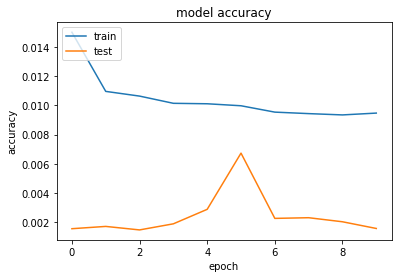

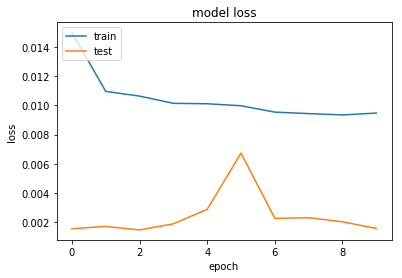

In [55]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

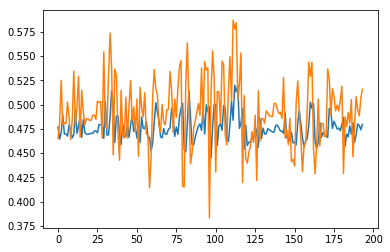

In [56]:
y_pred = model.predict(x_test)
plt.plot(y_pred)
plt.plot(y_test)
plt.show()

In [57]:
import util.trading_systems as ts

In [58]:
bl = int(items.getItemInfo(item)['buyLimit'])
print(len(x_test))
budgets = [10**5,10**6,10**7,10**8,10**9]
mpBest = [([-100],-1)] * len(budgets)
ppBest = [([-100],-1)] * len(budgets)
bhBest = [([-100],-1)] * len(budgets)
for b in range(len(budgets)):
    print(budgets[b])
    t = 0
    bhBest[b] = ts.buyAndHold(p_test,bl,budgets[b])
    for i in range(10):
        mp = ts.modelProfit(x_test,t,model,p_test,bl,budgets[b])
        if mp[-1]>mpBest[b][0][-1] and mp[-1]!=0.0:
            mpBest[b] = (mp,t)
        pp = ts.perfectProfit(x_test,t,y_test,p_test,bl,budgets[b])
        if pp[-1]>ppBest[b][0][-1]:
            ppBest[b] = (pp,t)
        t += .02

194
100000


1000000


10000000


100000000


1000000000


In [60]:
for b in range(len(budgets)):
    print(budgets[b])
    print('\tModel\n\t',mpBest[b][0][-1],mpBest[b][1])
    print('\tPerfect\n\t',ppBest[b][0][-1],ppBest[b][1])
    print('\tBuy and Hold\n\t',bhBest[b][-1])

100000
	Model
	 0.00481 0.04
	Perfect
	 0.4622 0
	Buy and Hold
	 -0.00468
1000000
	Model
	 0.00259 0.04
	Perfect
	 0.31449 0
	Buy and Hold
	 -0.00252
10000000
	Model
	 0.000259 0.04
	Perfect
	 0.033824 0
	Buy and Hold
	 -0.000252
100000000
	Model
	 2.59e-05 0.04
	Perfect
	 0.0033824 0
	Buy and Hold
	 -2.52e-05
1000000000
	Model
	 2.59e-06 0.04
	Perfect
	 0.00033824 0
	Buy and Hold
	 -2.52e-06


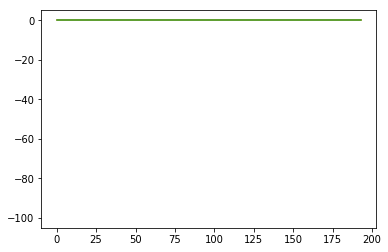

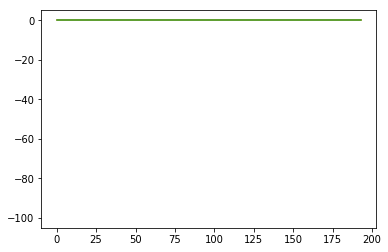

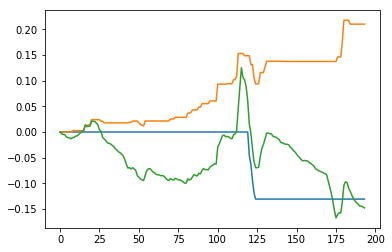

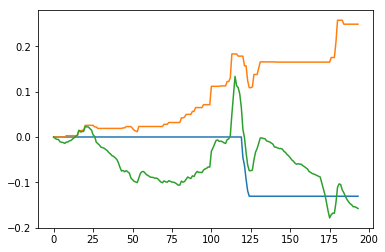

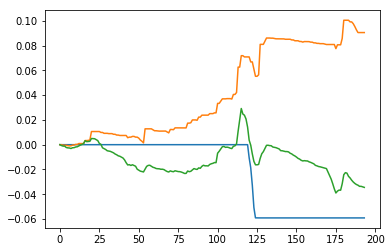

In [46]:
for b in range(len(budgets)):
    plt.plot(mpBest[b][0])
    plt.plot(ppBest[b][0])
    plt.plot(bhBest[b])
    plt.show()